# Orbit response 

In [1]:
import sys
import os
from os.path import join
import collections
from datetime import datetime
import importlib
import h5py
import numpy as np
from pprint import pprint
from tqdm import tqdm
from matplotlib import pyplot as plt
import proplot as pplt

from tools.data import H5Reader

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

In [3]:
folder = 'Diagnostics/Data/Measurements/orbit_response/2022-05-11/'
filenames = os.listdir(folder)
filenames

['220511102740-orbit_response-QH11_VS22_Cam09.h5',
 '220511101859-orbit_response-QH13_VS14_Cam09.h5',
 '220511103208-orbit_response-QV12_VS30_Cam09.h5',
 '220511103314-orbit_response-QV10_VS30_Cam09.h5',
 '220511103347-orbit_response-QV09_VS30_Cam09.h5',
 '220511102845-orbit_response-QV09_VS22_Cam09.h5',
 '220511102918-orbit_response-QH08_VS22_Cam09.h5',
 '220511102707-orbit_response-QV12_VS22_Cam09.h5',
 '220511102117-orbit_response-QV09_VS14_Cam09.h5',
 '220511102812-orbit_response-QV10_VS22_Cam09.h5',
 '220511103420-orbit_response-QH08_VS30_Cam09.h5',
 '220511103453-orbit_response-QV07_VS30_Cam09.h5',
 '220511102627-orbit_response-QH13_VS22_Cam09.h5',
 '220511102011-orbit_response-QH11_VS14_Cam09.h5',
 '220511102150-orbit_response-QH08_VS14_Cam09.h5',
 '220511102044-orbit_response-QV10_VS14_Cam09.h5',
 '220511103241-orbit_response-QH11_VS30_Cam09.h5',
 '220511102951-orbit_response-QV07_VS22_Cam09.h5',
 '220511103128-orbit_response-QH13_VS30_Cam09.h5',
 '220511101939-orbit_response-Q

In [4]:
class DataFile(H5Reader):
    def __init__(self, filename, folder='.'):
        super().__init__(filename, folder)
        self.quad, self.screen, self.cam = self.filename.split('-')[-1].split('.h5')[0].split('_')
        self.screen_int = self.screen[-2:]
        self.quad_int = self.quad[-2:]
        self.cam_int = self.cam[-2:]

Create nested dictionary of data files. 

In [11]:
dfiles_by_screen = dict()
for filename in filenames:
    df = DataFile(filename, folder)
    if df.screen not in dfiles_by_screen:        
        dfiles_by_screen[df.screen] = dict()
    dfiles_by_screen[df.screen][df.quad] = df

In [16]:
screens = sorted(list(dfiles_by_screen))
print('screens:', screens)
print('dfiles_by_screen:')
pprint(dfiles_by_screen)

screens: ['VS14', 'VS22', 'VS30']
dfiles_by_screen:
{'VS14': {'QH08': <__main__.DataFile object at 0x122a65f50>,
          'QH11': <__main__.DataFile object at 0x122a69210>,
          'QH13': <__main__.DataFile object at 0x1114f9d90>,
          'QV07': <__main__.DataFile object at 0x122a4d310>,
          'QV09': <__main__.DataFile object at 0x122a63d50>,
          'QV10': <__main__.DataFile object at 0x122a619d0>,
          'QV12': <__main__.DataFile object at 0x11272ef90>},
 'VS22': {'QH08': <__main__.DataFile object at 0x122a6b8d0>,
          'QH11': <__main__.DataFile object at 0x122a50c90>,
          'QH13': <__main__.DataFile object at 0x122a5f750>,
          'QV07': <__main__.DataFile object at 0x122a79d90>,
          'QV09': <__main__.DataFile object at 0x122a55f90>,
          'QV10': <__main__.DataFile object at 0x122a582d0>,
          'QV12': <__main__.DataFile object at 0x122a5ba50>},
 'VS30': {'QH08': <__main__.DataFile object at 0x122a4b310>,
          'QH11': <__main__.Dat

## Analysis

In [29]:
screen = 'VS14'
dfiles = dfiles_by_screen[screen]
quads = sorted(dfiles.keys(), key=lambda quad: int(quad[-2:]))
print('quads:', quads)

quads: ['QV07', 'QH08', 'QV09', 'QV10', 'QH11', 'QV12', 'QH13']


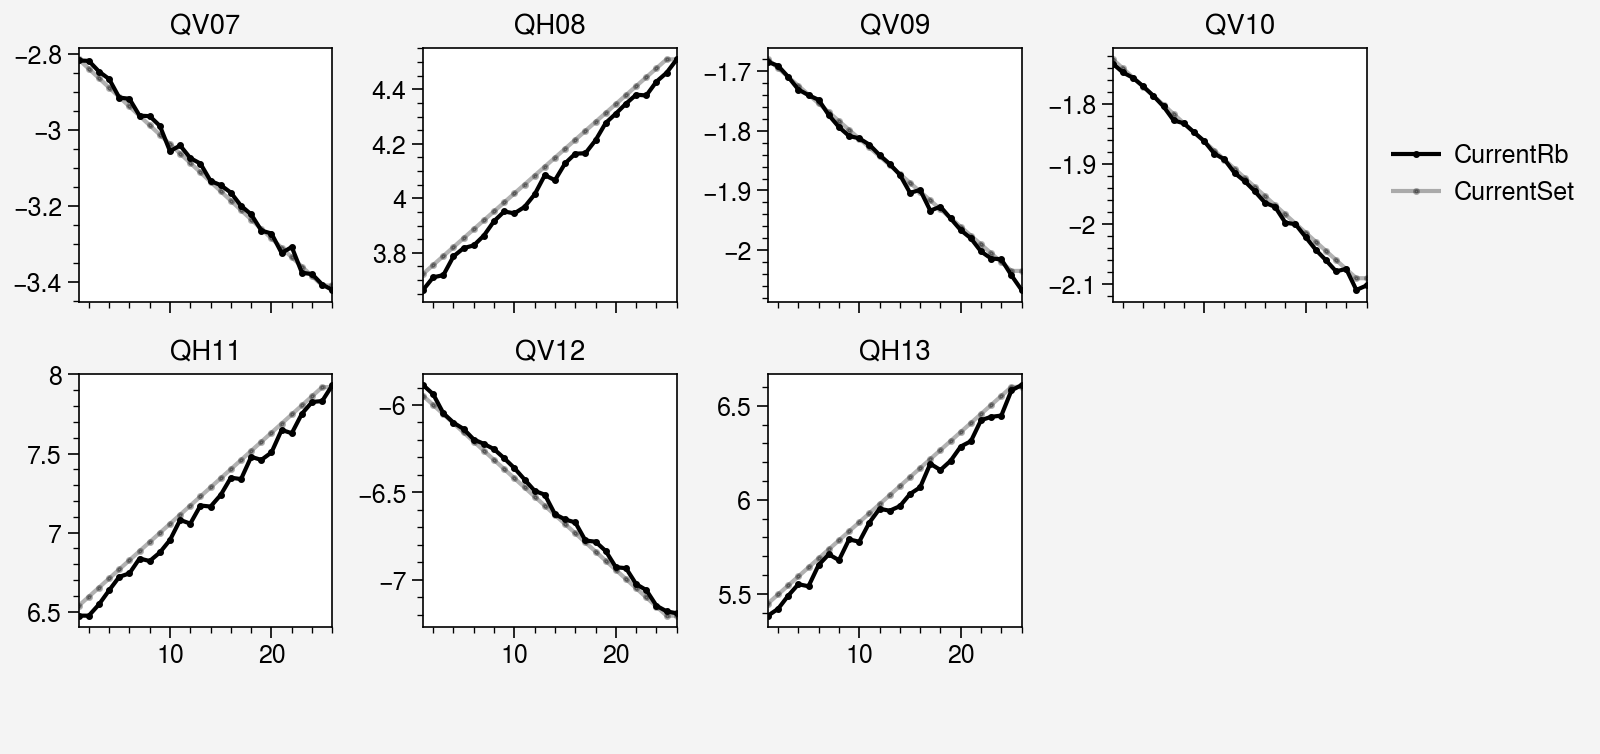

In [34]:
ncols = 4
nrows = int(np.ceil(len(dfiles) / ncols))   
overflow = nrows * ncols - len(quads)
istart = 1  # Ignore first data point.
kws = dict(marker='.', ms=3)

fig, axes = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=8.0, sharey=False)
for ax, quad in zip(axes, quads):
    data = dfiles[quad].data
    name_rb = quad + '_CurrentRb'
    name_set = quad + '_CurrentSet'
    x = np.arange(istart, len(df.data))
    ax.plot(x, data[istart:, name_rb], color='black', label='CurrentRb', **kws)
    ax.plot(x, data[istart:, name_set], color='black', alpha=0.3, label='CurrentSet', **kws)
    ax.set_title(quad)
axes[0, -1].legend(loc='r', ncols=1, framealpha=0)
for ax in axes[-overflow:]:
    ax.axis('off')
axes.format(xlabel='Step')